## Regression Model(boston)

In [1]:
%load_ext lab_black

In [2]:
# ライブラリーのインポート
import os
import logging
import tempfile
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# ボストンの住宅価格データ
from sklearn.datasets import load_boston

# 前処理
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ludwing
from ludwig.api import kfold_cross_validate, LudwigModel

# 評価指標
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

2021-08-30 12:30:32.549992: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-08-30 12:30:32.550263: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [3]:
# データセットの読込み
boston = load_boston()

# 説明変数の格納
df = pd.DataFrame(boston.data, columns=boston.feature_names)
# 目的変数の追加
df["MEDV"] = boston.target

# データの中身を確認
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


#### 前処理

In [4]:
# ランダムシード値
RANDOM_STATE = 10

# 学習データと評価データの割合
TEST_SIZE = 0.2

# 学習データと評価データを作成
x_train, x_test, y_train, y_test = train_test_split(
    df.iloc[:, 0 : df.shape[1] - 1],
    df.iloc[:, df.shape[1] - 1],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
)

train_df = pd.concat([x_train, y_train], axis=1)
test_df = pd.concat([x_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(404, 14)
(102, 14)


### Setup Ludwig config


In [5]:
num_features = boston.feature_names
target_features = ["MEDV"]

#### Create Ludwig input_features

In [6]:
input_features = []
# setup input features for numerical variables
for p in num_features:
    a_feature = {
        "name": p,
        "type": "numerical",
        "preprocessing": {
            "missing_value_strategy": "fill_with_mean",
            "normalization": "zscore",
        },
    }
    input_features.append(a_feature)

#### Create Ludwig output features

In [7]:
output_features = [
    {"name": "MEDV", "type": "numerical", "num_fc_layers": 2, "fc_size": 64}
]

In [8]:
config = {
    "input_features": input_features,
    "output_features": output_features,
    "training": {"epochs": 200, "batch_size": 32},
}
config

{'input_features': [{'name': 'CRIM',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'ZN',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'INDUS',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'CHAS',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'NOX',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'RM',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},
  {'name': 'AGE',
   'type': 'numerical',
   'preprocessing': {'missing_value_strategy': 'fill_with_mean',
    'normalization': 'zscore'}},


### Train model and assess model performance

In [9]:
model = LudwigModel(config=config, logging_level=logging.ERROR)

2021-08-30 12:30:52.531475: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-30 12:30:52.536204: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-30 12:30:52.536399: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (a5e58c64dcf3): /proc/driver/nvidia/version does not exist


In [10]:
%%time
RESULTS_DIR = 'results'
training_stats = model.train(
    training_set=train_df,
    output_directory=RESULTS_DIR,
)

2021-08-30 12:30:58.373592: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-08-30 12:31:12.893812: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


CPU times: user 1min 43s, sys: 8.06 s, total: 1min 51s
Wall time: 3min 27s


In [11]:
test_stats, mpg_hat_df, _ = model.evaluate(
    dataset=test_df, collect_predictions=True, collect_overall_stats=True
)

In [12]:
test_stats

{'MEDV': {'loss': 9.551726,
  'error': 0.048299313,
  'mean_squared_error': 9.551726,
  'mean_absolute_error': 2.2636738,
  'r2': 0.90866524},
 'combined': {'loss': 9.551726}}

/tmp/Python/python-3.9.6/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


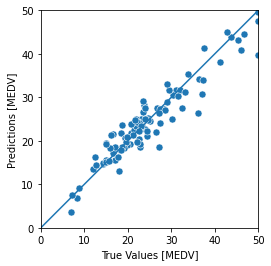

In [13]:
a = plt.axes(aspect="equal")
sns.scatterplot(test_df["MEDV"].values, mpg_hat_df["MEDV_predictions"].values, s=50)
plt.xlabel("True Values [MEDV]")
plt.ylabel("Predictions [MEDV]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

### Compare K-fold Cross Validation metrics against hold-out test metrics
#### Hold-out Test Metrics

In [14]:
test_stats["MEDV"]

{'loss': 9.551726,
 'error': 0.048299313,
 'mean_squared_error': 9.551726,
 'mean_absolute_error': 2.2636738,
 'r2': 0.90866524}

In [15]:
# 評価
def calculate_scores(true, pred):
    """全ての評価指標を計算する

    Parameters
    ----------
    true (np.array)       : 実測値
    pred (np.array)       : 予測値

    Returns
    -------
    scores (pd.DataFrame) : 各評価指標を纏めた結果

    """
    scores = {}
    scores = pd.DataFrame(
        {
            "R2": r2_score(true, pred),
            "MAE": mean_absolute_error(true, pred),
            "MSE": mean_squared_error(true, pred),
            "RMSE": np.sqrt(mean_squared_error(true, pred)),
        },
        index=["scores"],
    )
    return scores

In [16]:
scores = calculate_scores(y_test, mpg_hat_df["MEDV_predictions"])
print(scores)

              R2       MAE       MSE      RMSE
scores  0.908666  2.263674  9.551726  3.090587
